
## [**My github repo**](https://github.com/meiyihTan/WID3008_Image_Processing) 

In [18]:
#Check GPU resources
!nvidia-smi

Fri Dec 31 18:20:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#Import lib
import os
import sys
import cv2
from matplotlib import pyplot as plt
import sys
import json
import numpy as np
import base64
from PIL import Image, ImageDraw


%matplotlib inline

In [2]:
#Clone and build face-alignment git repo

'''
Here we build face-alignment for face recognition
This face-alignment git repo help to detect facial landmarks, to detect points(find facial landmarks) of the initial face .
The facial landmarks provide pose, expression and shape information.
When matching,a mask face to a frontal unmask one, knowledge of these landmarks is useful for establishing correspondence which can 
help improve recognition.
Facial landmarks also used for face cropping in order to remove scale, rotation and translation variations.

'''
!git clone https://github.com/1adrianb/face-alignment
%cd face-alignment
!pip install -r requirements.txt
!python setup.py install
import face_alignment

Cloning into 'face-alignment'...
remote: Enumerating objects: 1026, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1026 (delta 24), reused 34 (delta 13), pack-reused 969
Receiving objects: 100% (1026/1026), 5.26 MiB | 3.70 MiB/s, done.
Resolving deltas: 100% (625/625), done.
/content/face-alignment
running install
running bdist_egg
running egg_info
creating face_alignment.egg-info
writing face_alignment.egg-info/PKG-INFO
writing dependency_links to face_alignment.egg-info/dependency_links.txt
writing requirements to face_alignment.egg-info/requires.txt
writing top-level names to face_alignment.egg-info/top_level.txt
writing manifest file 'face_alignment.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'face_alignment.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/face_alignme

In [3]:
#Download and import face mask SDK
!git clone https://github.com/meiyihTan/WID3008_Image_Processing.git
%cd WID3008_Image_Processing
from masked_face_sdk.mask_generation_utils import \
(extract_target_points_and_characteristic,extract_polygon,rotate_image_and_points, draw_landmarks,warp_mask,get_traingulation_mesh_points_indexes,end2end_mask_generation)


Cloning into 'WID3008_Image_Processing'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (295/295), done.
remote: Total 297 (delta 10), reused 254 (delta 2), pack-reused 0
Receiving objects: 100% (297/297), 47.28 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/face-alignment/WID3008_Image_Processing


In [4]:
# Generate 2D landmark estimator using the face_alignment library import from (face-alignment git repo)
# face-alignment library help to extract keypoints(find facial landmarks) of the initial face(person with mask)
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cpu')

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

['data/masked_faces/55.male-doctor-wearing-medical-mask-looking-camera-isolated-white-background-179445420.jpg', 'data/masked_faces/8.portrait-sick-man-wearing-medical-mask-infection-text-blue-background-coronavirus-concept-protect-your-health-171324727.jpg', 'data/masked_faces/87.ee5d0dfc-9fa3-49a9-a8e9-3915aa00abbd.jpg', 'data/masked_faces/7.sliding-cropped-portrait-male-doctor-wearing-protective-medical-mask-posing-confidently-green-chromakey-background-medical-128050529.jpg', 'data/masked_faces/6.inline_image_preview.jpg', 'data/masked_faces/70.cambodia_china_outbreak_51805.jpg', 'data/masked_faces/8.16193653-close-up-image-of-a-female-doctor-wearing-medical-mask-and-gloves.jpg', 'data/masked_faces/80.covid-mask-616.jpg', 'data/masked_faces/23.students_with_masks_10_june_2015.jpg', 'data/masked_faces/127760847-blond-young-woman-wearing-medical-mask-adjusting-it-with-her-hands-close-up-isolated-white-backgroun.jpg', 'data/masked_faces/40.teenager-boy-wearing-respiratory-protective-m

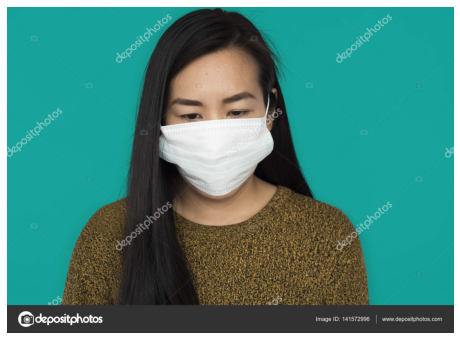

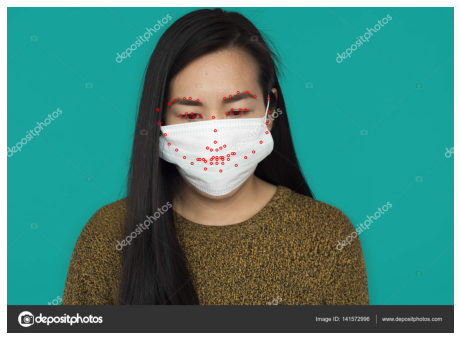

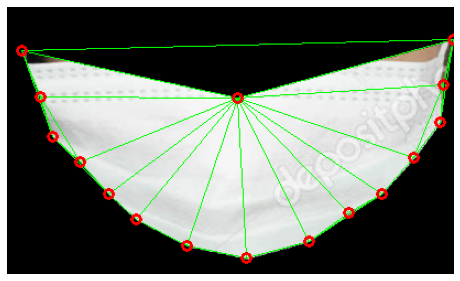

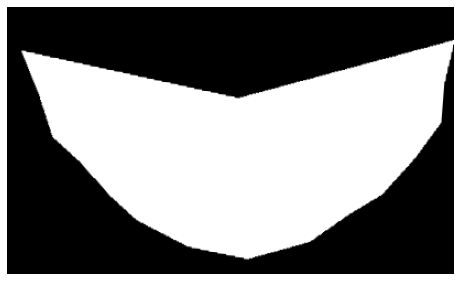

In [14]:
#Plot mask triangulation
'''
In this cropping and triangulation process, about 250 masks will be extracted from the
handcrafted dataset with the medical masks,https://drive.google.com/file/d/1vQf0hX6K-nKpH8O_42wPDfGF6v9lmZoi/view (provided by the author of broutonlab repo)
which will be then use to match to other persons(into image of a person's face without a medical mask)
'''
#Path to the handcrafted dataset with the medical mask
masked_faces_images_pathes = [os.path.join('data/masked_faces/', img_name)for img_name in os.listdir('data/masked_faces/')]
print(masked_faces_images_pathes)

#Here we take an example image from the handcrafted masked_faces dataset 
example_image = cv2.cvtColor(cv2.imread(masked_faces_images_pathes[75]), cv2.COLOR_BGR2RGB)

#get landmarks of this example image using the 2D landmark estimator we generated/initialised just now 
landmarks = fa.get_landmarks_from_image(example_image)
landmarks = np.floor(landmarks[0]).astype(np.int32)

#Plot the example image 
plt.figure(figsize=(8, 8))
plt.imshow(example_image)
plt.axis('off')

#Plot/draw the landmarks of the example image 
plt.figure(figsize=(8, 8))
plt.imshow(draw_landmarks(example_image, landmarks, color=(255, 0, 0), thickness=4))
plt.axis('off')

#Extract the target_points and characteristic from the landmarks of this example image (from mask_generation_utils file import from masked_face_sdk)
#Here avg_left_eye_point,avg_right_eye_point,avg_mouth_point,left_face_point,right_face_point is included 
target_points, s1, s2 = extract_target_points_and_characteristic(landmarks)

#Extract polygon of this example image using the target points
mask_rgba_crop, target_points = extract_polygon(example_image, target_points)

"""
Rotates an image (angle in degrees) and expands image 
"""
# rotate the example image with the new bounds and translated rotation matrix 
mask_rgba_crop, target_points = rotate_image_and_points(mask_rgba_crop, s1, target_points)

#get triangulation (triangles indexes) using the target points
triangles_indexes = get_traingulation_mesh_points_indexes(target_points)

mask_rgba_crop_vis = mask_rgba_crop[..., :3].copy().astype(np.uint8)

#Loop through the triangles indexes
for triangle in triangles_indexes:
    triangle_points = target_points[triangle]
    
    mask_rgba_crop_vis = cv2.line(mask_rgba_crop_vis,tuple(triangle_points[0]),tuple(triangle_points[1]),(0, 255, 0),1)  
    mask_rgba_crop_vis = cv2.line(mask_rgba_crop_vis,tuple(triangle_points[1]),tuple(triangle_points[2]),(0, 255, 0),1)
    mask_rgba_crop_vis = cv2.line(mask_rgba_crop_vis,tuple(triangle_points[0]),tuple(triangle_points[2]),(0, 255, 0),1)

#Plot the triangulation for cropped mask based on the triangles indexes
plt.figure(figsize=(8, 8))
plt.imshow(draw_landmarks(mask_rgba_crop_vis, target_points, color=(255, 0, 0), thickness=4))
plt.axis('off')

#Plot the cropped mask
plt.figure(figsize=(8, 8))
plt.imshow(mask_rgba_crop[..., 3], 'gray')
plt.axis('off')


plt.show()

In [24]:
#Here I prepare some images for testing (including my passport photo submitted in week 1)
img_list=['data/y.jpg','data/t.jpg','data/r.jpg','data/v.jpg','data/w.jpg','data/z.jpg','data/s.jpg','data/j.jpg','data/x.jpg','data/i.jpg','data/h.jpg','data/g.jpg','data/f.jpg','data/e.jpg','data/d.jpg','data/c.jpg','data/b.jpg','data/a.jpg','data/hx.jpg','data/b1.jpg','data/b3.jpg','data/f1.jpg','data/yhx.jpg','data/tmy_passport2.jpg','data/tuto3_2.jpg','data/maha.jpg','data/smile.jpg','data/map.jpg']

In [ ]:
# Face matching example
def face_matching(test_img):
  rows=1
  columns=3
  target_image = cv2.cvtColor(cv2.imread(test_img, cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)

  #get landmarks of the input testing image using the 2D landmark estimator  
  landmarks2 = fa.get_landmarks_from_image(target_image)
  landmarks2 = np.floor(landmarks2[0]).astype(np.int32)
  
  #Extract the target_points and characteristic from the landmarks of testing image 
  target_points2, _, _ = extract_target_points_and_characteristic(landmarks2)

  #Extract polygon, rotate and get triangulation (triangles indexes) using the landmarks 
  target_image_with_mask = warp_mask(mask_rgba_crop[..., :3],target_image,target_points,target_points2)
  mask_rgba_crop_vis = target_image_with_mask.copy().astype(np.uint8)

  #Loop through the triangles indexes
  for triangle in triangles_indexes:
      triangle_points = target_points2[triangle]
      
      mask_rgba_crop_vis = cv2.line(mask_rgba_crop_vis, tuple(triangle_points[0]),tuple(triangle_points[1]),(0, 255, 0),3)
      mask_rgba_crop_vis = cv2.line(mask_rgba_crop_vis,tuple(triangle_points[1]),tuple(triangle_points[2]),(0, 255, 0),3)
      mask_rgba_crop_vis = cv2.line(mask_rgba_crop_vis,tuple(triangle_points[0]),tuple(triangle_points[2]),(0, 255, 0),3)
  
  #Plot the testing image 
  fig = plt.figure(figsize=(10, 7))
  fig.add_subplot(rows, columns, 1)
  plt.imshow(target_image)
  plt.axis('off')

  #Plot/draw the landmarks of the testing image 
  fig.add_subplot(rows, columns, 2)
  plt.imshow(draw_landmarks(mask_rgba_crop_vis, target_points2, color=(255, 0, 0), thickness=4))
  plt.axis('off')

  #Plot the testing image with mask
  fig.add_subplot(rows, columns, 3)
  plt.imshow(target_image_with_mask)
  plt.axis('off')
  plt.show()
  return target_image

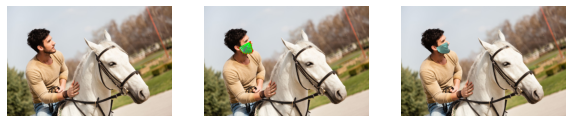

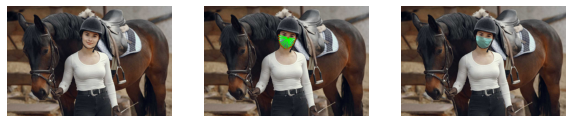

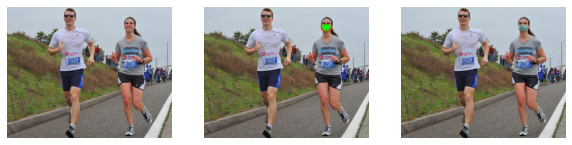

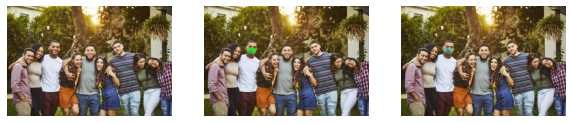

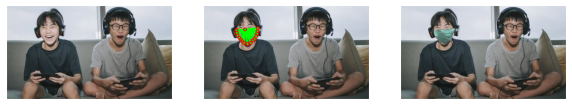

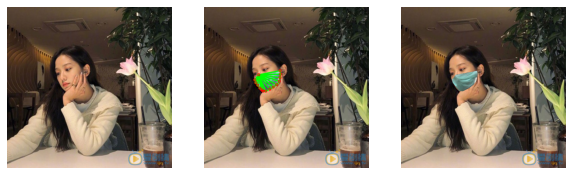

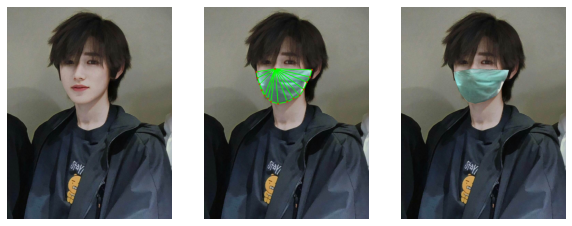

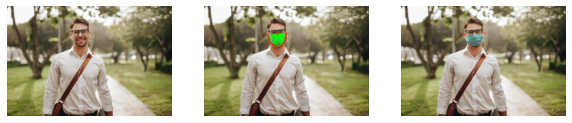

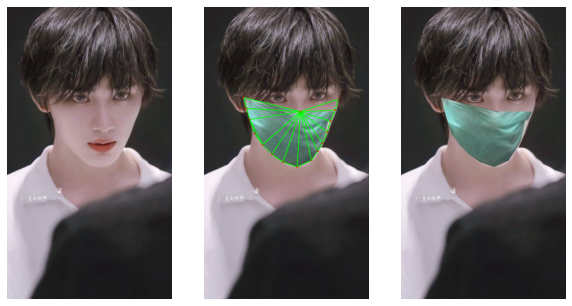

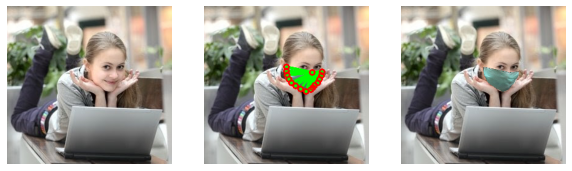

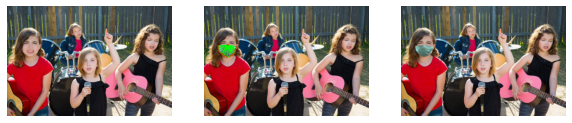

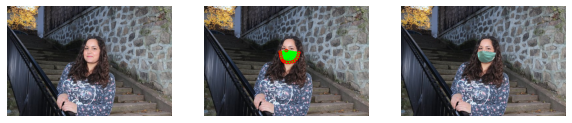

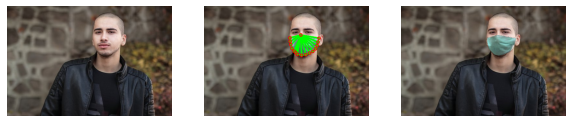

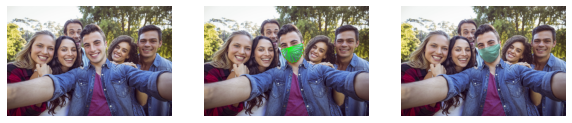

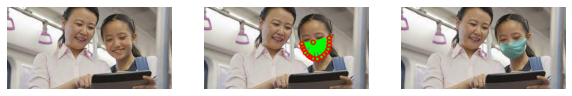

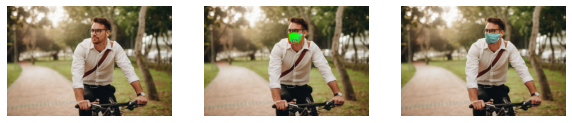

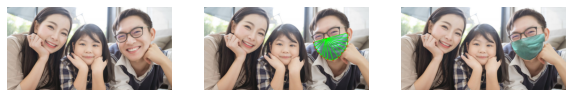

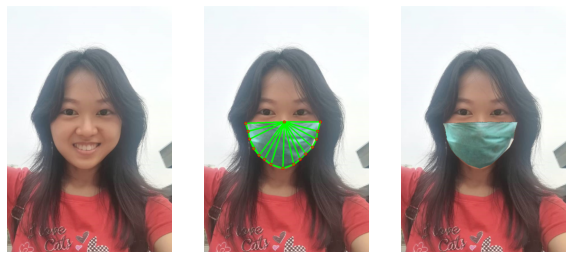

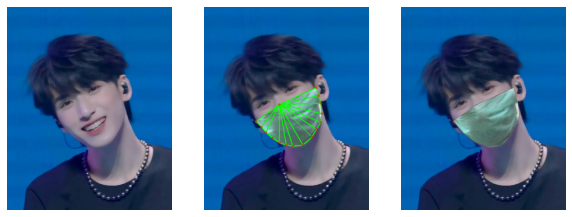

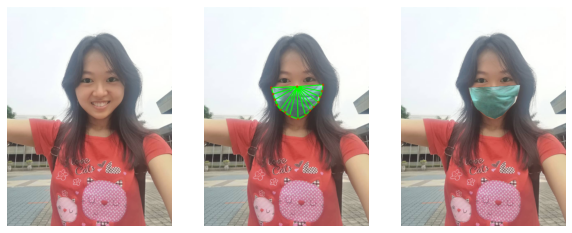

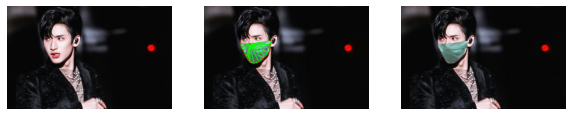

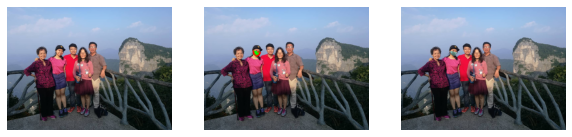

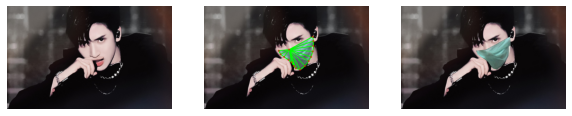

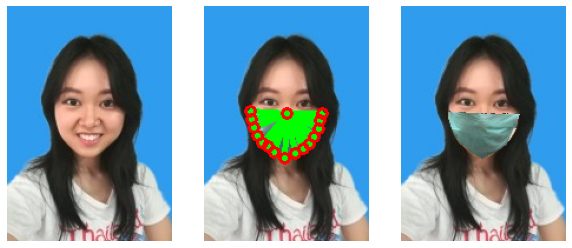

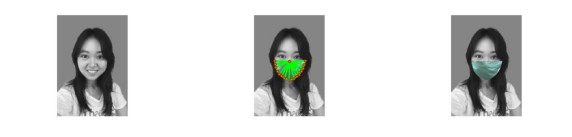

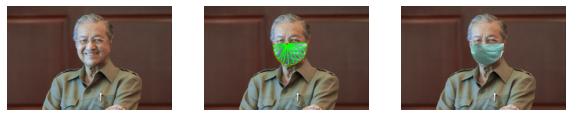

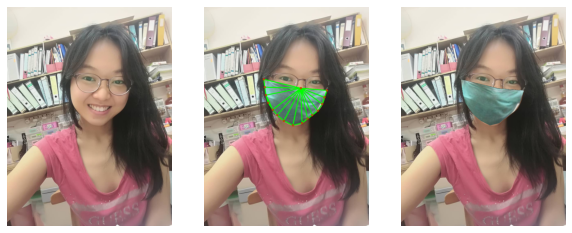

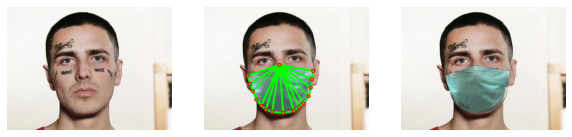

In [ ]:
for img in img_list:
  face_matching(img)

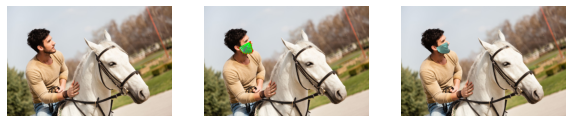

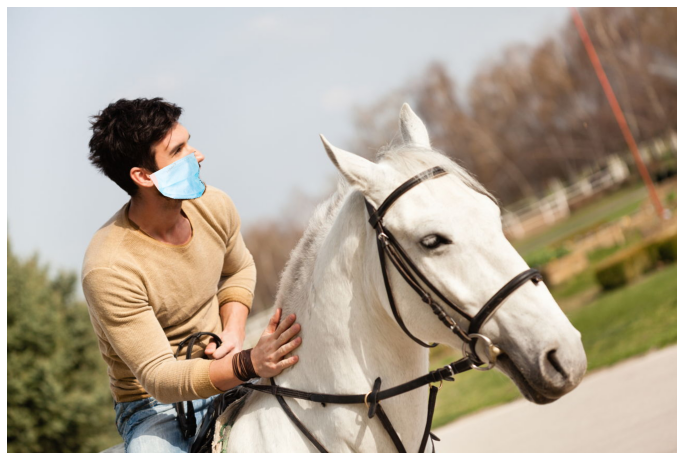

In [ ]:
#Download database and plot the results
target_image=face_matching(img_list[0])
with open('data/masks_base.json', 'r') as jf:
    masks_database = json.load(jf)
target_image_with_mask = end2end_mask_generation(target_image, masks_database, fa)

plt.figure(figsize=(12, 12))
plt.imshow(target_image_with_mask)
plt.axis('off')
plt.show()